# **CSC mixed multivariate time series anomaly detector implementation:**

In [ ]:
# !pip install alphacsc

In [ ]:
import numpy as np
# from alphacsc import learn_d_z
# from alphacsc.utils import construct_X
from scipy.linalg import toeplitz

from scipy.signal import argrelmax
import matplotlib.pyplot as plt
from scipy.fft import fftn, fft, ifft, rfft, rfftn, irfft

## Utils functions

In [ ]:
def soft_thresholding(x, gamma):
  result = 0
  if np.abs(x) - gamma > 0:
    result = np.sign(np.real(x))*(np.abs(x) - gamma)
  return result

soft_thresholding = np.vectorize(soft_thresholding)

In [ ]:
def shrinkage_operator(x, beta):
  resul = 0
  if np.linalg.norm(x) > beta:
    resul = (np.linalg.norm(x) - beta)*x/np.linalg.norm(x)
  return resul

In [ ]:
def inv_util_func(x, y, rho):
  return x/(rho + y)

inv_util_func = np.vectorize(inv_util_func)

In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax  

## I- Data preprocessing

In [ ]:
!pip install loadmydata

In [ ]:
import pandas as pd
from scipy.signal import argrelmax
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
    load_trial,
)

**Interesting dataset from:**

http://www.ipol.im/pub/art/2019/265/article.pdf

In [ ]:
code_list = get_code_list()
print(code_list)

In [ ]:
data = load_human_locomotion_dataset('1-2')
raw_signal = load_trial('157-4')
raw_signal.head()

In [ ]:
# Check for null values
null_values = raw_signal.isnull().values.any()

In [ ]:
# Normalize the data
for column in raw_signal.columns[1:]:
  raw_signal[column] = (raw_signal[column] - raw_signal[column].mean())/raw_signal[column].std()

In [ ]:
# Choose a subset for the first test
signal = raw_signal.to_numpy()[550:3800, 3:5].T

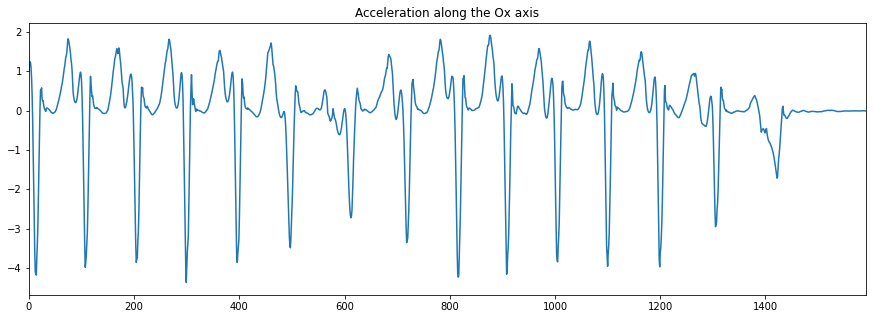

In [ ]:
fig, ax = fig_ax()   
ax.plot(signal[0])
_ = ax.set_title("Acceleration along the Ox axis")

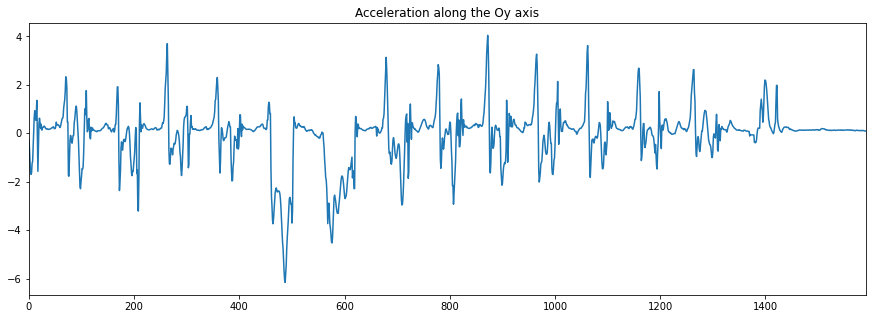

In [ ]:
fig, ax = fig_ax()   
ax.plot(signal[1])
_ = ax.set_title("Acceleration along the Oy axis")

## II- Dictionary learning

In [ ]:
!pip install sporco

In [ ]:
from sporco.pgm.cbpdn import ConvBPDN
from sporco.pgm import pgm

In [ ]:
class A_ProxG(ConvBPDN):

    """ Accelerated proximal gradient in the frequency domain """

    # def __init__(self, D, S, lmbda, opt=None, dimK=None, dimN=2):
    #     super(update_dx, self).__init__(D, S, lmbda, opt, dimK=dimK, dimN=dimN)

    
    def prox_g(self, d_m):

    """ Compute proximal operator of indicator function of the unit ball """

        result = d_m
        if np.linalg.norm(d_m) > 1:
          result = d_m/np.linalg.norm(d_m)

        return result

In [ ]:
def ADMM_learn_dx(init_d_fft, signal_fft, lambd, nb_iter=50, rho=1):

  """" Compute activations in the dictionary learning stage; solves the ADMM consensus CONVOLUTIONAL SPARSE CODING problem 
  Implementation of the algorithm proposed in:
  B. Wohlberg Efficient convolutional sparse coding, 
  2014 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)

  Args: 
        init_d_fft: FFT of dictionary iterate
        signal_fft: FFT of the signal 
        lambd: regularization constant 
        nb_iter: number of iterations      
  """""

  nb_dictionaries = init_d_fft.shape[1]
  len_signal = len(signal_fft)

  # matrix of FFT of conv operator
  D_hat_m = tuple( np.diag(init_d_fft[:, i]) for i in range(nb_dictionaries) ) 
  D_hat_full = np.concatenate(D_hat_m)

  # initialize dual variables
  y = np.zeros((nb_dictionaries, len_signal))
  u = np.zeros((nb_dictionaries, len_signal))
  b_n = np.empty((nb_dictionaries, len_signal))

  for idx_iter in range(nb_iter):
      # b_n: optimization sub-problem auxiliary variable
      
      for i in range(nb_dictionaries):
        b_n[i] = np.conjugate(np.diag(init_d_fft[:, i])) @signal_fft + rho*(u[i] - y[i])  
      comp_dot_prod = np.sum(init_d_fft.T*b_n, axis=0)
      x_hat = b_n - inv_util_func(comp_dot_prod, np.linalg.norm(init_d_fft, axis=1) , rho)*init_d_fft.T

      # get x_m by computing the inverse FT, x_m is the activations matrix 
      x_m = ifft(x_hat, axis=1) 

      # update dual variables
      y = soft_thresholding(x_m+ u, lambd/rho) 
      u += (x_m - y).real  

  return x_m

In [ ]:
def learn_dx(signal, lambd, nb_iter, nb_dict, dict_len):

  " Learn the dictionaries to use for anomaly detection "
  " ADMM consensus CONVOLUTIONAL SPARSE setting "

  nb_dims, signal_len = signal.shape
  opt = ConvBPDN.Options({'MaxMainIter': 50}) 
  learned_dict = np.random.randn(nb_dims, dict_len, nb_dict)
  signal_hat = fft(signal)
  x_m = np.zeros((nb_dims, nb_dict, signal_len))

  for idx_iter in range(nb_iter):
    
    # compute the fft of the dict iterate
    D_hat = fftn(learned_dict, s=signal_len, axes=1)

    for dim in range(nb_dims):
      
      # activations iteration 
      x_m[dim] = ADMM_learn_dx(D_hat[dim], signal_hat[dim], lambd, nb_iter=50, rho=1)
      
      # dictionary iteration 
      comp = A_ProxG(x_m[dim], signal[dim], lambd, opt, dimN=1) 
      result = comp.solve()    
      learned_dict[dim] = result[:dict_len,:,:, :nb_dict].reshape((dict_len, nb_dict)) # [:dict_len-1].reshape((dict_len, nb_dict))  


  return x_m, learned_dict
  

## III- Anomaly detection

In [ ]:
def update_activations(D_hat, loc_s_fft, z_fft, lambd, beta=1, rho=1):

  """ Update activations in the anomaly detection step """

  signal_len, nb_dictionaries = D_hat.shape

  # matrix of FFT of conv operator

  # b_n: optimization sub-problem auxiliary variable
  b_n = np.empty((nb_dictionaries, signal_len))
  for i in range(nb_dictionaries):
    b_n[i] = np.conjugate(np.diag(D_hat[:, i])) @loc_s_fft + rho*z_fft[i]  
  comp_dot_prod = np.sum(D_hat.T*b_n, axis=0)
  x_hat = b_n - inv_util_func(comp_dot_prod, np.linalg.norm(D_hat, axis=1) , rho)*D_hat.T

  # get x_m by computing the inverse FT, x_m is the activations matrix 
  x_m = ifft(x_hat, axis=1) 

  return x_m

In [ ]:
def learn_anomaly_vec(D, signal, lambd, beta, nb_iter, rho=1):

  """  Learn anomaly vector to perform detection, on a single window  """

  # signal has shape (nb_dimensions, signal_length)
  signal_len = signal.shape[1]
  nb_dims, len_dict, nb_dictionaries = D.shape
  # compute the FFT of the provided dictionaries 
  # D has shape (nb_dimensions, len(d), nb_dictionaries)
  D_hat = fftn(D, s=signal_len, axes=1)

  # anomaly (term) matrix
  anom_vec = np.zeros((nb_dims, signal_len))
  # matrix to store activations 
  x_m = np.zeros((nb_dims, nb_dictionaries, signal_len))
  # Dual variables of the corresponding ADMM optimization problem
  Y = np.zeros(( nb_dictionaries, signal_len))
  U = np.zeros((nb_dims, nb_dictionaries, signal_len))

  for idx_iter in range(nb_iter):
    
    for dim in range(nb_dims):

      # compute FFT of biased signall s - e
      loc_s_fft = fft(signal[dim] - anom_vec[dim], signal_len) 
      # z: optimization sub-problem auxiliary variable 
      z_fft = fftn(Y - U[dim], signal_len)

      # update activations x_m
      x_m[dim] = update_activations(D_hat[dim], loc_s_fft, z_fft, lambd, beta, rho=1)

      # Compute conv
      conv_vec = np.array([np.convolve(D[dim,  :, i], x_m[dim,  i, : ], mode="same") for i in range(nb_dictionaries)]) 

      # update anomalies
      anom_vec[dim] = shrinkage_operator(signal[dim] - np.sum(conv_vec, axis=0), beta)

    # update dual and auxiliary variables of the (main) ADMM optimization problem
    Y = soft_thresholding( np.sum(x_m+U, axis=0)/nb_dims, lambd/rho)
    Y_aug = np.array([Y for _ in range(nb_dims)])
    U += x_m - Y_aug

  return x_m, np.sum(anom_vec, axis=1)  

In [ ]:
def Anomaly_detector(signal, lambd, detect_window_len, nb_iter, beta, nb_dict, dict_len, detec_threshold):
  
  """ Returns the windows containing anomalies and their corresponding indices  """

  nb_dims = signal.shape[0]
  signal_len = signal.shape[1]
  nb_detect_windows = int(signal_len/detect_window_len) 

  # Learn dictionaries
  x_m_dict, learned_dict = learn_dx(signal, lambd, nb_iter, nb_dict, dict_len)
    
  # Compute anomaly vector for each detection window   
  anom_vec = np.empty(( nb_dims,  nb_detect_windows ))     
  
  # x_m = np.empty((nb_detect_windows, nb_dims, nb_dict, signal_len))
  window = np.arange(detect_window_len) 
  for idx_w in range(nb_detect_windows):
    _, anom_vec[:, idx_w] = learn_anomaly_vec(learned_dict, signal[:, window + idx_w*detect_window_len], lambd, beta, nb_iter, rho=1)

  # Detection rule: if ||anom_vec[:, idx_w]|| > threshold then the window contains an anomaly
  scores = np.linalg.norm(anom_vec, axis=0)
  print("scores = ", scores)    
  anomaly_indices = np.where(scores > detec_threshold)[0]
  anomaly_windows = [signal[:, window + i*detect_window_len] for i in anomaly_indices]

  return anomaly_windows, anomaly_indices  

In [ ]:
#------------------------
# COMPUTING ANOMALIES
#------------------------   

lambd = 0.01
detect_window_size = 200
nb_iter = 1
beta = .1
nb_dict = 10 
dict_len = 50
detec_threshold = 18

anomaly_windows, anomaly_indices = Anomaly_detector(signal, lambd, detect_window_size, nb_iter, beta, nb_dict, dict_len, detec_threshold)


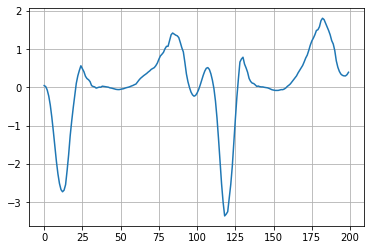

In [ ]:
plt.plot(np.arange(detect_window_size), anomaly_windows[2][0])
plt.grid(True)
plt.show()

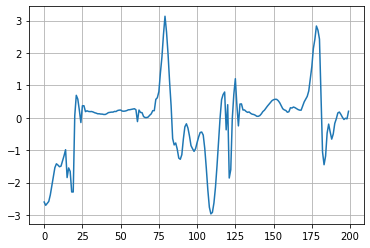

In [ ]:
plt.plot(np.arange(detect_window_size), anomaly_windows[2][1])
plt.grid(True)
plt.show()